Last Sunday we received an unusual signal during a routine observation with the Allen Telescope Array 20-antenna beamformer. Experts believe that the signal originates from outside the solar system.

flag{TK6NP9LA}

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.coordinates import SkyCoord, EarthLocation, GCRS
from astropy.time import Time
import astropy.units as u
import astropy.constants as const
import scipy.signal
import sigmf

plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
vega = SkyCoord.from_name('Vega')
ata = EarthLocation.from_geodetic(-(121 + 28/60 + 24/3600), 40 + 49/60 + 3/3600, 1008)

t = Time('2022-09-26T02:07:05') + np.linspace(0, 1, 1000) * u.hour

velocity = -vega.radial_velocity_correction(kind='heliocentric', obstime=t, location=ata).to(u.m/u.s)

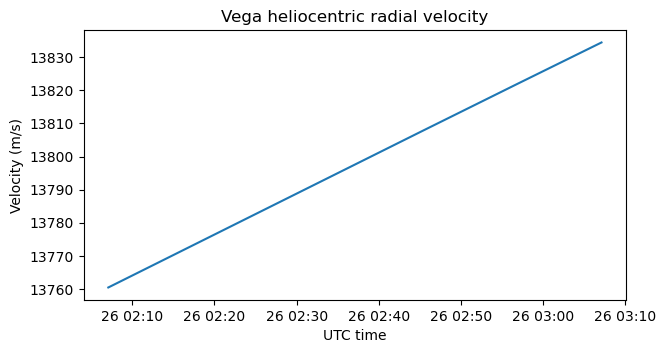

In [3]:
plt.plot(t.datetime, velocity)
plt.title('Vega heliocentric radial velocity')
plt.ylabel('Velocity (m/s)')
plt.xlabel('UTC time');

In [4]:
f_HI = 1420.4057517682e6 * u.Hz
f_carrier = 4 * f_HI
f_doppler = -velocity / const.c * f_carrier
f_centre = 5681.361e6 * u.Hz
f_baseband = f_carrier + f_doppler - f_centre

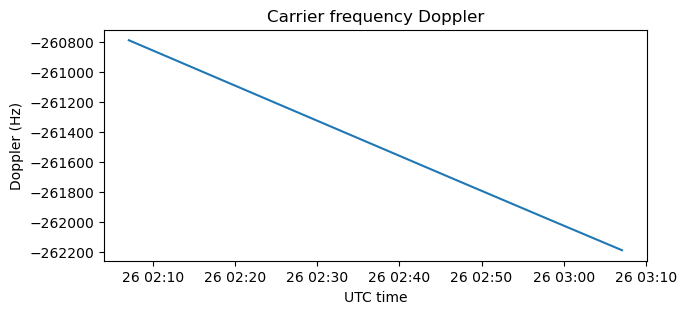

In [5]:
plt.figure(figsize=(7, 3))
plt.plot(t.datetime, f_doppler)
plt.title('Carrier frequency Doppler')
plt.ylabel('Doppler (Hz)')
plt.xlabel('UTC time');

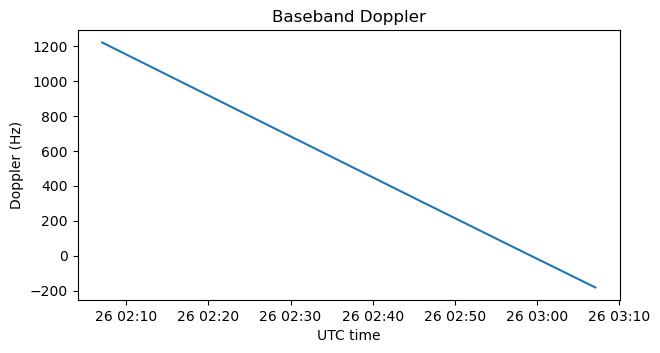

In [6]:
plt.plot(t.datetime, f_baseband)
plt.title('Baseband Doppler')
plt.ylabel('Doppler (Hz)')
plt.xlabel('UTC time');

Text(0.5, 0, 'Time')

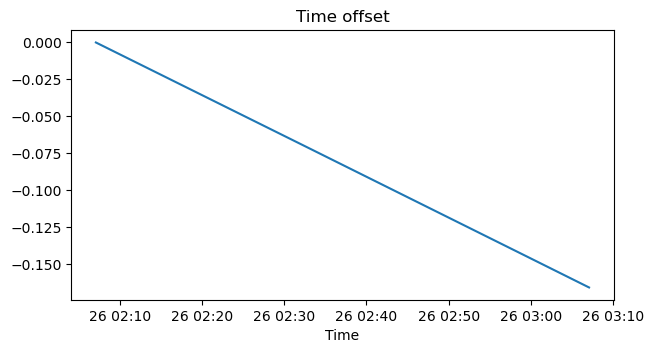

In [7]:
distance = np.cumsum(0.5 * (velocity[:-1] + velocity[1:]) * (t[1:] - t[:-1]).to(u.s))
distance = np.concatenate([[0 * u.m], distance])
time_offset = -distance / const.c
plt.plot(t.datetime, time_offset)
plt.title('Time offset')
plt.xlabel('Time')

In [8]:
3600 * 10e3 * 4 * 1e-6

144.0

In [9]:
256 * 256

65536

In [10]:
256 * 2 * 128

65536

In [11]:
f_pixel = f_HI / 2**26
print(f_pixel)
(256 * 256 / f_pixel).to(u.h)

21.165695067766308 Hz


<Quantity 0.86009197 h>

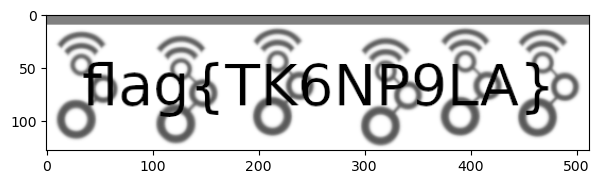

In [12]:
img = mpimg.imread('vega_ctf.png')[..., 0]
img_ravel = img.T.ravel()
plt.imshow(img, cmap='gray')

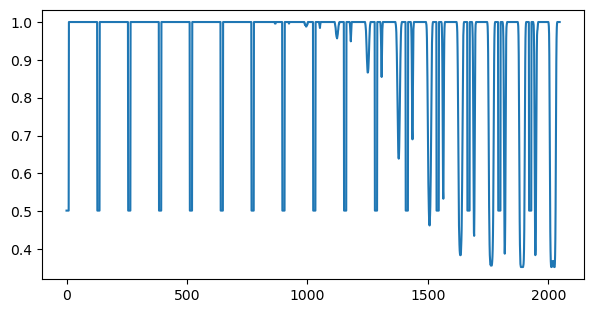

In [13]:
plt.plot(img.T.ravel()[:2048])

In [14]:
symbols_per_pixel = 2**6
f_symbol = f_pixel * symbols_per_pixel
f_symbol

<Quantity 1354.60448434 Hz>

In [15]:
Nsym = symbols_per_pixel * img_ravel.size
symbols_interp = np.repeat(img_ravel, symbols_per_pixel)
symbols_R = 0.5 * (np.random.randn(Nsym) + 1j*np.random.randn(Nsym)) * np.sqrt(symbols_interp)
symbols_L = 0.5 * (np.random.randn(Nsym) + 1j*np.random.randn(Nsym)) * np.sqrt(1 - symbols_interp)
symbols_X = symbols_R + symbols_L
symbols_Y = 1j * (symbols_R - symbols_L)

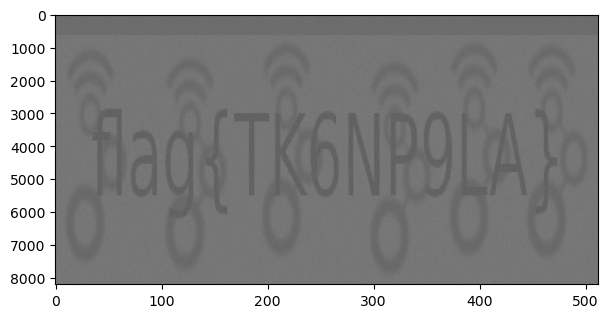

In [16]:
plt.imshow((np.abs(symbols_R)**2 - np.abs(symbols_L)**2).reshape(-1, 128*2**6).T, cmap='gray', aspect='auto')

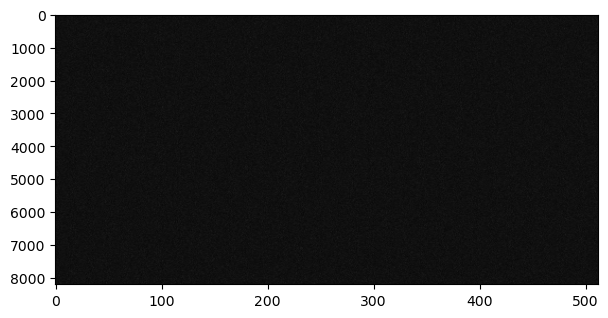

In [17]:
plt.imshow((np.abs(symbols_X)**2).reshape(-1, 128*2**6).T, cmap='gray', aspect='auto')

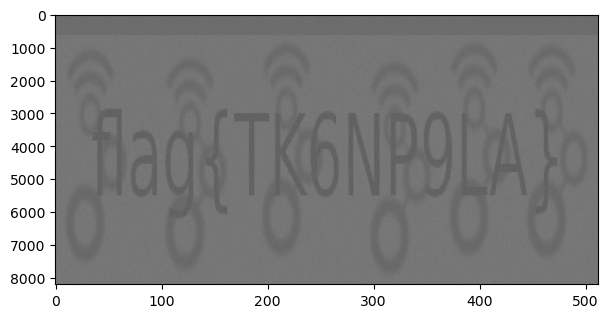

In [18]:
plt.imshow(-np.imag(symbols_X*np.conjugate(symbols_Y)).reshape(-1, 128*2**6).T, cmap='gray', aspect='auto')

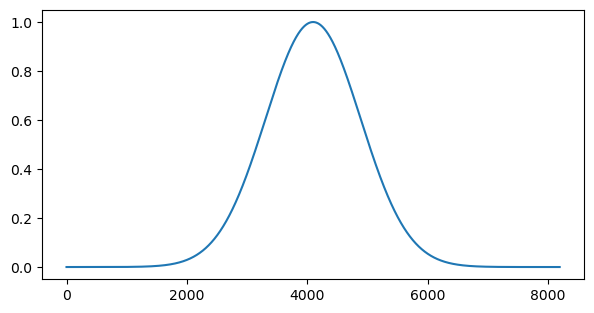

In [19]:
f_bw = 880 * u.Hz
Npolyphase = 512
Ntaps = 16
prototype_fir = scipy.signal.windows.gaussian(Npolyphase*Ntaps, Npolyphase / f_bw * f_symbol)
plt.plot(prototype_fir)

In [20]:
fs_out = 6e3 * u.Hz
syms_per_sample = f_symbol / fs_out
Nsamples = int(fs_out.value * 3600)

In [21]:
symbols_per_pulse = 2**10
pulse_freq = f_symbol / symbols_per_pulse
pulse_freq

<Quantity 1.32285594 Hz>

In [22]:
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61]
prime_pulses = ('0'*8).join([('10'*p)[:-1] for p in primes]) + '0'*8
prime_pulses = np.array([int(a) for a in prime_pulses])
prime_symbols = np.repeat(prime_pulses, symbols_per_pulse)

In [23]:
time_offset_interp = np.interp(np.arange(Nsamples) / fs_out.value, (t - t[0]).to(u.s).value, time_offset)
start_offset = int(symbols_X.size * 0.772873)
ts = np.arange(Nsamples) * syms_per_sample + (time_offset_interp * f_symbol).value + start_offset
ts_int = np.array(np.int32(ts))
ts_frac = ts % 1
polyphase_arm = np.array(Npolyphase - 1 - np.int32(np.floor((ts_frac) * Npolyphase)))
symbols_X2 = np.tile(symbols_X, 2)
symbols_Y2 = np.tile(symbols_Y, 2)
prime_amplitude = np.tile(0.7482 * prime_symbols + 1,
                          int(np.ceil(symbols_X2.size / prime_symbols.size)))[:symbols_X2.size]
symbols_X2 = symbols_X2 * prime_amplitude
symbols_Y2 = symbols_Y2 * prime_amplitude

In [24]:
%%time

samples_X = np.zeros(Nsamples, 'complex64')
samples_Y = np.zeros(Nsamples, 'complex64')
for n in range(Nsamples):
    w = prototype_fir[polyphase_arm[n]::Npolyphase]
    samples_X[n] = np.sum(symbols_X2[ts_int[n]:][:Ntaps] * w)
    samples_Y[n] = np.sum(symbols_Y2[ts_int[n]:][:Ntaps] * w)

CPU times: user 11min 1s, sys: 35.8 s, total: 11min 37s
Wall time: 10min 57s


In [25]:
f_baseband_interp = np.interp(np.arange(Nsamples) / fs_out.value, (t - t[0]).to(u.s).value, f_baseband.value)
phase = np.cumsum(2 * np.pi * f_baseband_interp / fs_out.value) % (2 * np.pi)

In [26]:
doppler_exp = np.exp(1j * phase)
scale = 0.1
samples_X = scale * (
    samples_X * doppler_exp + 2 * (np.random.randn(samples_X.size) + 1j * np.random.randn(samples_X.size)))
samples_Y = scale * (
    samples_Y * doppler_exp + 2 * (np.random.randn(samples_X.size) + 1j * np.random.randn(samples_X.size)))

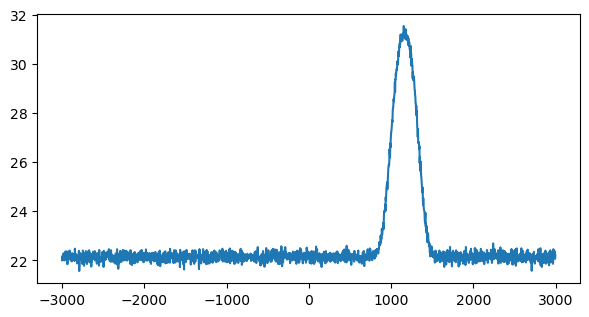

In [27]:
Nfft = 2048
freqaxs = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs_out))
plt.plot(freqaxs,
    10*np.log10(np.fft.fftshift(
    np.average(np.abs(np.fft.fft(samples_X[:6000*60*5//Nfft*Nfft].reshape(-1, Nfft)))**2, axis=0))))

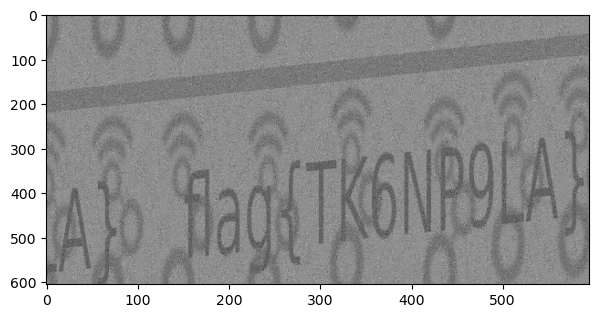

In [28]:
z = samples_X * np.conjugate(samples_Y)
w = np.abs(samples_X)**2 + np.abs(samples_Y)**2
avg = 60
z = np.average(z[:z.size//avg*avg].reshape(-1, avg), axis=-1)
w = np.average(w[:w.size//avg*avg].reshape(-1, avg), axis=-1)
z = -z.imag / w**4
L = round(128 / f_pixel.value * fs_out.value / avg)
plt.imshow(z[:z.size//L*L].reshape(-1, L).T, cmap='gray', aspect='auto')

In [29]:
mjd = f'{t[0].mjd:.5f}'.replace('.', '_')
fname = [f'ATA_{mjd}_HIP91262_pol{pol}.sigmf-data' for pol in 'XY']
for samp, fn in zip([samples_X, samples_Y], fname):
    np.round((2**7 * samp).astype('complex64').view('float32')).astype('int8').tofile(fn)

In [30]:
for fn, pol in zip(fname, 'XY'):
    # create the metadata
    meta = sigmf.SigMFFile(
        data_file=fn, # extension is optional
        global_info = {
            sigmf.SigMFFile.DATATYPE_KEY: 'ci8',
            sigmf.SigMFFile.SAMPLE_RATE_KEY: 6000,
            sigmf.SigMFFile.AUTHOR_KEY: 'Daniel Estevez <daniel@destevez.net>',
            sigmf.SigMFFile.DESCRIPTION_KEY: (
                f'HIP91262 ATA 20-antenna beamformer polarization {pol} '
                '(GRCon22 CTF)'),
            sigmf.SigMFFile.VERSION_KEY: sigmf.__version__,
        }
    )

    # create a capture key at time index 0
    meta.add_capture(0, metadata={
        sigmf.SigMFFile.FREQUENCY_KEY: int(f_centre.value),
        sigmf.SigMFFile.DATETIME_KEY: t[0].datetime.isoformat()+'Z',
    })

    # check for mistakes & write to disk
    assert meta.validate()
    meta.tofile(fn[:-4] + 'meta') # extension is optional

In [31]:
# see https://stackoverflow.com/a/54908072 for how to tar the files